In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import pytz

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping

2024-02-25 01:15:53.800509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading Data

In [2]:
# Fetch stock data and earnings dates with improved error handling
def fetch_stock_data_with_earnings(ticker, period):
    try:
        stock = yf.Ticker(ticker)

        data = stock.history(period=period)
        data.index = data.index.date

        earnings = stock.earnings_dates
        earnings.index = earnings.index.date
        
        return data, earnings
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None, None

In [3]:
# Fetch stock data
ticker = "TSLA"
period = "1y"

data, earnings = fetch_stock_data_with_earnings(ticker, period)
if data is None:
    raise ValueError("Failed to fetch stock data.")

In [4]:
# Fetch S&P 500 historical data
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period=period)
sp500_data.index = sp500_data.index.date

data_sp500 = sp500_data[['Close']] 
data_sp500.columns = ['SP500_Close']    # Rename the columns for clarity and to avoid conflicts upon merging

# Merge the S&P 500 data with your existing DataFrame based on the date index
data = data.merge(data_sp500, how='left', left_index=True, right_index=True)

# Drop 'Dividends' and 'Stock Splits' and compute additional technical indicators
data = data.drop(columns=['Dividends', 'Stock Splits'])

data.tail()

,Open,High,Low,Close,Volume,SP500_Close
2024-02-16,202.059998,203.169998,197.399994,199.949997,111173600,5005.569824
2024-02-20,196.130005,198.600006,189.130005,193.759995,104545800,4975.509766
2024-02-21,193.360001,199.440002,191.949997,194.770004,103844000,4981.799805
2024-02-22,194.000000,198.320007,191.360001,197.410004,92739500,5087.029785
2024-02-23,195.309998,197.570007,191.500000,191.970001,78670300,5088.799805


In [5]:
# Function to check if the current time is within trading hours
def is_trading_hours():
    # Define US Eastern timezone
    eastern = pytz.timezone('US/Eastern')
    
    # Get current time in Eastern timezone
    now_eastern = datetime.datetime.now(eastern)
    
    # Define market open and close times (9:30 AM to 4:00 PM)
    market_open = now_eastern.replace(hour=9, minute=30, second=0, microsecond=0)
    market_close = now_eastern.replace(hour=16, minute=0, second=0, microsecond=0)
    
    # Check if current time is within trading hours
    return market_open <= now_eastern <= market_close


# Check if it's trading hours before dropping the first row
if is_trading_hours():
    print('Trading Hour.')
    data = data.drop(data.tail(1).index)    # Drop the last row from the DataFrame
else:
    print('After Hour.')

After Hour.


## Feature Engineering

In [6]:
short_span, long_span = 10, 50

data['EMA_Short'] = data['Close'].ewm(span=short_span, adjust=False).mean()
data['EMA_Long'] = data['Close'].ewm(span=long_span, adjust=False).mean()

# data['SMA_Short'] = data['Close'].rolling(window=short_span).mean()
# data['SMA_Long'] = data['Close'].rolling(window=long_span).mean()

# RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2

### EMA (Exponential Moving Average)
- EMA is a type of moving average that places a greater weight and significance on the most recent data points. It is more responsive to new information compared to the SMA.
- Usage in analysis: EMA is often used to identify the direction of the trend, with prices above the EMA suggesting an uptrend and prices below indicating a downtrend. Traders might use short-term EMAs to make quick, momentum-based decisions and longer-term EMAs for overall trend direction.

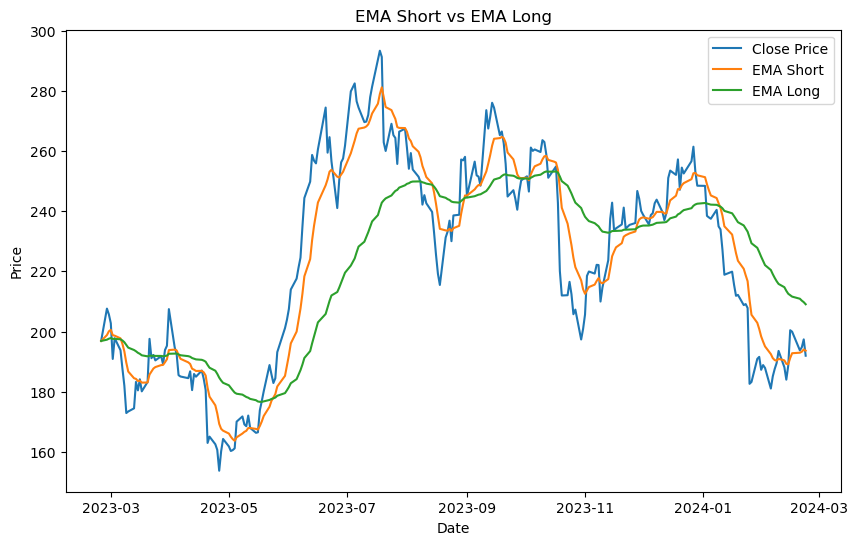

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Close Price')
plt.plot(data.index, data['EMA_Short'], label='EMA Short')
plt.plot(data.index, data['EMA_Long'], label='EMA Long')
plt.title('EMA Short vs EMA Long')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### RSI (Relative Strength Index)
- RSI is a momentum oscillator that measures the speed and change of price movements on a scale of 0 to 100. It is used to identify overbought or oversold conditions in a security's price.
- Usage in analysis: Values above 70 are considered overbought (suggesting a potential sell signal), while values below 30 are considered oversold (indicating a potential buy signal). RSI can also show divergence signals, where the price trend and RSI trend move in opposite directions, suggesting a potential reversal.

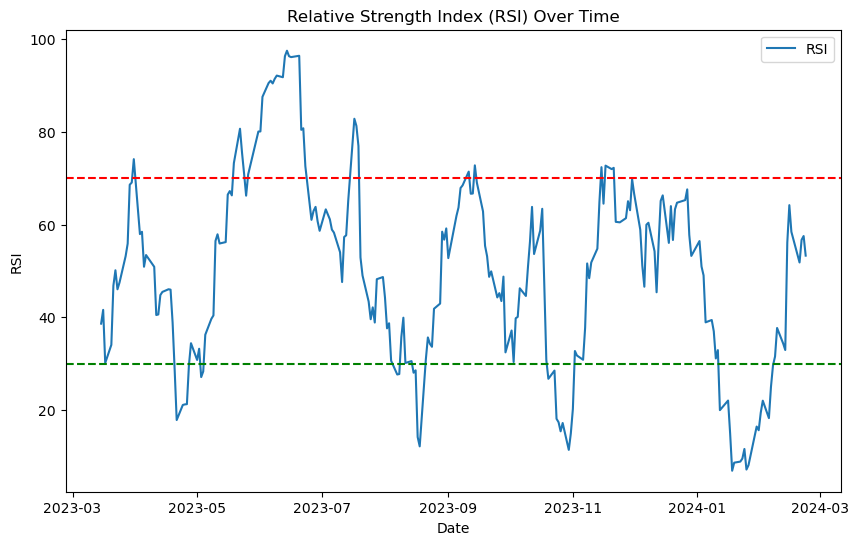

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['RSI'], label='RSI')
plt.title('Relative Strength Index (RSI) Over Time')
plt.xlabel('Date')
plt.axhline(70, linestyle='--', color='red')  # Overbought line
plt.axhline(30, linestyle='--', color='green')  # Oversold line
plt.ylabel('RSI')
plt.legend()
plt.show()

### MACD (Moving Average Convergence Divergence)
- MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It consists of the MACD line (difference between two EMAs), a signal line (EMA of the MACD line), and a histogram (difference between MACD and its signal line).
- Usage in analysis: MACD is used to identify changes in the strength, direction, momentum, and duration of a trend. A bullish crossover occurs when the MACD crosses above its signal line, suggesting a buy signal, while a bearish crossover (MACD falls below the signal line) suggests a sell signal. The divergence between the MACD and price action can also indicate potential market reversals.

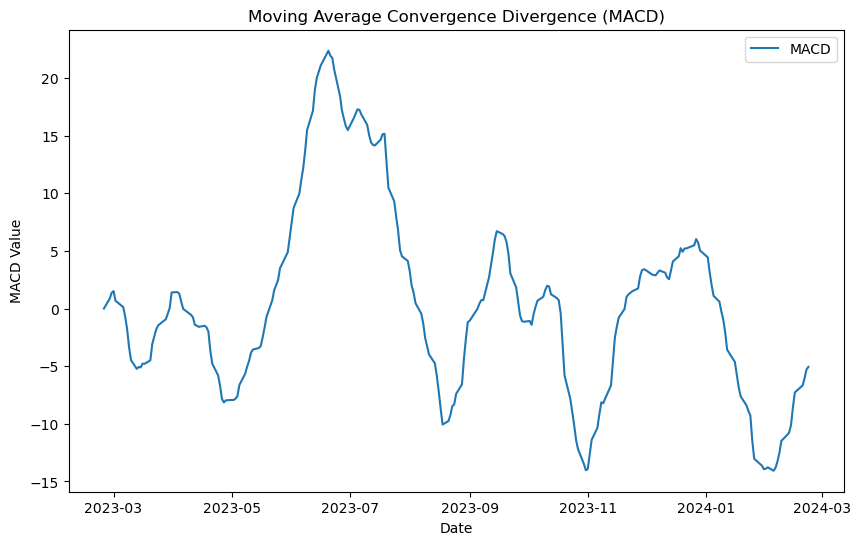

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['MACD'], label='MACD')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.show()

In [10]:
data

,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,RSI,MACD
2023-02-24,196.330002,197.669998,192.800003,196.880005,142228100,3970.040039,196.880005,196.880005,NaN,0.000000
2023-02-27,202.029999,209.419998,201.259995,207.630005,161028300,3982.239990,198.834550,197.301574,NaN,0.857550
2023-02-28,210.589996,211.229996,203.750000,205.710007,153144900,3970.149902,200.084633,197.631316,NaN,1.366485
2023-03-01,206.210007,207.199997,198.520004,202.770004,156852800,3951.389893,200.572883,197.832833,NaN,1.515120
2023-03-02,186.740005,193.750000,186.009995,190.899994,181500700,3981.350098,198.814176,197.560957,NaN,0.667410
...,...,...,...,...,...,...,...,...,...,...
2024-02-16,202.059998,203.169998,197.399994,199.949997,111173600,5005.569824,192.799912,211.611909,58.458365,-7.271002
2024-02-20,196.130005,198.600006,189.130005,193.759995,104545800,4975.509766,192.974473,210.911834,51.843668,-6.676731
2024-02-21,193.360001,199.440002,191.949997,194.770004,103844000,4981.799805,193.300933,210.278821,56.731468,-6.054476
2024-02-22,194.000000,198.320007,191.360001,197.410004,92739500,5087.029785,194.048037,209.774161,57.549002,-5.287359


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 2023-02-24 to 2024-02-23
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         251 non-null    float64
 1   High         251 non-null    float64
 2   Low          251 non-null    float64
 3   Close        251 non-null    float64
 4   Volume       251 non-null    int64  
 5   SP500_Close  251 non-null    float64
 6   EMA_Short    251 non-null    float64
 7   EMA_Long     251 non-null    float64
 8   RSI          238 non-null    float64
 9   MACD         251 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 29.7+ KB


## Data Preprocessing

In [12]:
# Normalize features
features = data.columns.tolist()

# Backward Fill
data[features] = data[features].bfill()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a DataFrame for the scaled data, ensuring to convert features_to_scale back to a list to maintain order
scaled_data_df = pd.DataFrame(scaled_data, columns=features, index=data.index)

# Display the scaled dataframe
scaled_data_df

,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,RSI,MACD
2023-02-24,0.304672,0.267920,0.294787,0.308976,0.525683,0.092682,0.282480,0.264176,0.350206,0.386067
2023-02-27,0.344421,0.352568,0.356471,0.385988,0.653861,0.102576,0.299116,0.269681,0.350206,0.409591
2023-02-28,0.404114,0.365608,0.374626,0.372233,0.600113,0.092771,0.309757,0.273986,0.350206,0.423552
2023-03-01,0.373570,0.336575,0.336493,0.351171,0.625393,0.077556,0.313912,0.276618,0.350206,0.427630
2023-03-02,0.237796,0.239680,0.245279,0.266137,0.793441,0.101854,0.298943,0.273068,0.350206,0.404375
...,...,...,...,...,...,...,...,...,...,...
2024-02-16,0.344630,0.307543,0.328327,0.330969,0.313955,0.932500,0.247752,0.456542,0.568797,0.186607
2024-02-20,0.303278,0.274620,0.268028,0.286625,0.268767,0.908121,0.249238,0.447401,0.495796,0.202909
2024-02-21,0.283961,0.280671,0.288589,0.293861,0.263982,0.913223,0.252017,0.439135,0.549739,0.219979
2024-02-22,0.288424,0.272603,0.284287,0.312773,0.188273,0.998565,0.258376,0.432545,0.558761,0.241023


## Take earnings into consideration

In [13]:
# merge earnings data
scaled_data_df = scaled_data_df.merge(earnings, how='left', left_index=True, right_index=True)

# Forward Fill for the head rows
scaled_data_df = scaled_data_df.fillna(method='ffill')

# Backward Fill for the tail rows
scaled_data_df = scaled_data_df.fillna(method='bfill')

# Display the merged dataframe
scaled_data_df

/var/folders/hd/pv9sg75d6b38kvxtq9c67bw40000gn/T/ipykernel_80747/4154407146.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_data_df = scaled_data_df.fillna(method='ffill')
/var/folders/hd/pv9sg75d6b38kvxtq9c67bw40000gn/T/ipykernel_80747/4154407146.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_data_df = scaled_data_df.fillna(method='bfill')


,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,RSI,MACD,EPS Estimate,Reported EPS,Surprise(%)
2023-02-24,0.304672,0.267920,0.294787,0.308976,0.525683,0.092682,0.282480,0.264176,0.350206,0.386067,0.85,0.85,-0.0004
2023-02-27,0.344421,0.352568,0.356471,0.385988,0.653861,0.102576,0.299116,0.269681,0.350206,0.409591,0.85,0.85,-0.0004
2023-02-28,0.404114,0.365608,0.374626,0.372233,0.600113,0.092771,0.309757,0.273986,0.350206,0.423552,0.85,0.85,-0.0004
2023-03-01,0.373570,0.336575,0.336493,0.351171,0.625393,0.077556,0.313912,0.276618,0.350206,0.427630,0.85,0.85,-0.0004
2023-03-02,0.237796,0.239680,0.245279,0.266137,0.793441,0.101854,0.298943,0.273068,0.350206,0.404375,0.85,0.85,-0.0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-16,0.344630,0.307543,0.328327,0.330969,0.313955,0.932500,0.247752,0.456542,0.568797,0.186607,0.74,0.71,-0.0439
2024-02-20,0.303278,0.274620,0.268028,0.286625,0.268767,0.908121,0.249238,0.447401,0.495796,0.202909,0.74,0.71,-0.0439
2024-02-21,0.283961,0.280671,0.288589,0.293861,0.263982,0.913223,0.252017,0.439135,0.549739,0.219979,0.74,0.71,-0.0439
2024-02-22,0.288424,0.272603,0.284287,0.312773,0.188273,0.998565,0.258376,0.432545,0.558761,0.241023,0.74,0.71,-0.0439


In [14]:
scaled_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 2023-02-24 to 2024-02-23
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          251 non-null    float64
 1   High          251 non-null    float64
 2   Low           251 non-null    float64
 3   Close         251 non-null    float64
 4   Volume        251 non-null    float64
 5   SP500_Close   251 non-null    float64
 6   EMA_Short     251 non-null    float64
 7   EMA_Long      251 non-null    float64
 8   RSI           251 non-null    float64
 9   MACD          251 non-null    float64
 10  EPS Estimate  251 non-null    float64
 11  Reported EPS  251 non-null    float64
 12  Surprise(%)   251 non-null    float64
dtypes: float64(13)
memory usage: 35.6+ KB


In [15]:
# Make 'Close' the last column
columns = [col for col in scaled_data_df.columns if col != 'Close']  # Get all columns except 'Close'
columns.append('Close')  # Add 'Close' to the end of the list

scaled_data_df = scaled_data_df[columns]

scaled_data_df

,Open,High,Low,Volume,SP500_Close,EMA_Short,EMA_Long,RSI,MACD,EPS Estimate,Reported EPS,Surprise(%),Close
2023-02-24,0.304672,0.267920,0.294787,0.525683,0.092682,0.282480,0.264176,0.350206,0.386067,0.85,0.85,-0.0004,0.308976
2023-02-27,0.344421,0.352568,0.356471,0.653861,0.102576,0.299116,0.269681,0.350206,0.409591,0.85,0.85,-0.0004,0.385988
2023-02-28,0.404114,0.365608,0.374626,0.600113,0.092771,0.309757,0.273986,0.350206,0.423552,0.85,0.85,-0.0004,0.372233
2023-03-01,0.373570,0.336575,0.336493,0.625393,0.077556,0.313912,0.276618,0.350206,0.427630,0.85,0.85,-0.0004,0.351171
2023-03-02,0.237796,0.239680,0.245279,0.793441,0.101854,0.298943,0.273068,0.350206,0.404375,0.85,0.85,-0.0004,0.266137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-16,0.344630,0.307543,0.328327,0.313955,0.932500,0.247752,0.456542,0.568797,0.186607,0.74,0.71,-0.0439,0.330969
2024-02-20,0.303278,0.274620,0.268028,0.268767,0.908121,0.249238,0.447401,0.495796,0.202909,0.74,0.71,-0.0439,0.286625
2024-02-21,0.283961,0.280671,0.288589,0.263982,0.913223,0.252017,0.439135,0.549739,0.219979,0.74,0.71,-0.0439,0.293861
2024-02-22,0.288424,0.272603,0.284287,0.188273,0.998565,0.258376,0.432545,0.558761,0.241023,0.74,0.71,-0.0439,0.312773


## Training

In [16]:
num_layers = 1
size_layer = 100
epochs = 20
dropout_rate = 0.2
reg_rate = 0.0001
batch_size = 5

In [17]:
data_list = scaled_data_df.values

test_size = 30

training_data = data_list[:-test_size]  # data for training and cross-validation
final_test_data = data_list[-test_size:]  # data points for final validation

len(training_data), len(final_test_data)

(221, 30)

In [18]:
# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# LSTM model with l1_l2 Regularization and Dropout
def build_model(input_shape, num_layers=2, size_layer=128, dropout_rate=0.2, reg_rate=0.01):
    model = Sequential()
    reg = l1_l2(l1=reg_rate, l2=reg_rate)

    for i in range(num_layers):
        return_sequences = i < num_layers - 1
        model.add(Bidirectional(LSTM(size_layer, return_sequences=return_sequences, kernel_regularizer=reg), input_shape=input_shape))
        
        if return_sequences:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error') # adagrad
    
    return model

# Setup early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [19]:
best_val_loss = np.inf
best_model = None
best_history = None


# Cross-validate using TimeSeriesSplit
for train_index, val_index in tscv.split(training_data):
    X_train, X_val = training_data[train_index, :-1], training_data[val_index, :-1]  # Exclude 'Close' from features
    y_train, y_val = training_data[train_index, -1], training_data[val_index, -1]  # 'Close' as target

    # Reshape input for LSTM [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Create and fit the LSTM model
    model = build_model(input_shape=(X_train.shape[1], X_val.shape[2]),
                        num_layers=num_layers,
                        size_layer=size_layer,
                        dropout_rate=dropout_rate,
                        reg_rate=reg_rate,
                        )

    # Fit the model with Early Stopping
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(
        X_val, y_val), callbacks=[early_stopping], verbose=1)
    
    # Track the best model based on validation loss
    val_loss = np.min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history

Epoch 1/20
9/9 [==============================] - 5s 187ms/step - loss: 0.0856 - val_loss: 0.0830
Epoch 2/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0634 - val_loss: 0.0742
Epoch 3/20
9/9 [==============================] - 0s 28ms/step - loss: 0.0549 - val_loss: 0.0685
Epoch 4/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0479 - val_loss: 0.0654
Epoch 5/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0413 - val_loss: 0.0538
Epoch 6/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0366 - val_loss: 0.0481
Epoch 7/20
9/9 [==============================] - 0s 25ms/step - loss: 0.0318 - val_loss: 0.0439
Epoch 8/20
9/9 [==============================] - 0s 25ms/step - loss: 0.0279 - val_loss: 0.0390
Epoch 9/20
9/9 [==============================] - 0s 10ms/step - loss: 0.0243 - val_loss: 0.0345
Epoch 10/20
9/9 [==============================] - 0s 20ms/step - loss: 0.0213 - val_loss: 0.0308
Epoch 11/20
9/9 [=============

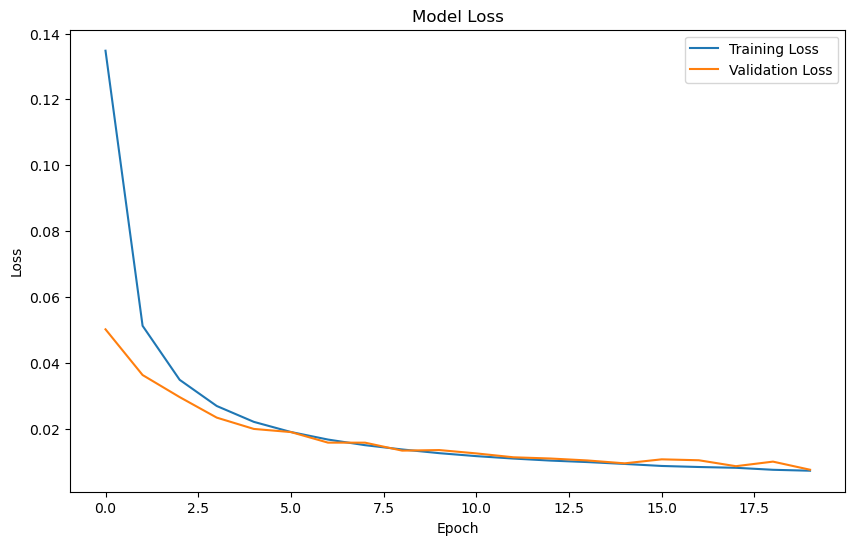

In [20]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Use the best model from cross-validation

# Prepare the entire training dataset
X_final_train = training_data[:, :-1]
y_final_train = training_data[:, -1]
print(len(X_final_train), len(y_final_train))

X_final_train = X_final_train.reshape((X_final_train.shape[0], 1, X_final_train.shape[1]))

# Re-train the best model on the entire training dataset (excluding the final validation set)
best_model.fit(X_final_train, y_final_train, epochs=epochs, batch_size=batch_size, verbose=1)

221 221
Epoch 1/20
45/45 [==============================] - 3s 2ms/step - loss: 0.0069
Epoch 2/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 3/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 4/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 5/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 6/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 7/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 8/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 9/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 10/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 11/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 12/20
45/45 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 13/20
45/45 [======================

## Testing

In [22]:
# Prepare the final test data
X_final_test = final_test_data[:, :-1]
y_final_test = final_test_data[:, -1]
X_final_test = X_final_test.reshape((X_final_test.shape[0], 1, X_final_test.shape[1]))

# Make predictions on the final validation set
final_predictions = best_model.predict(X_final_test)

1/1 [==============================] - 3s 3s/step


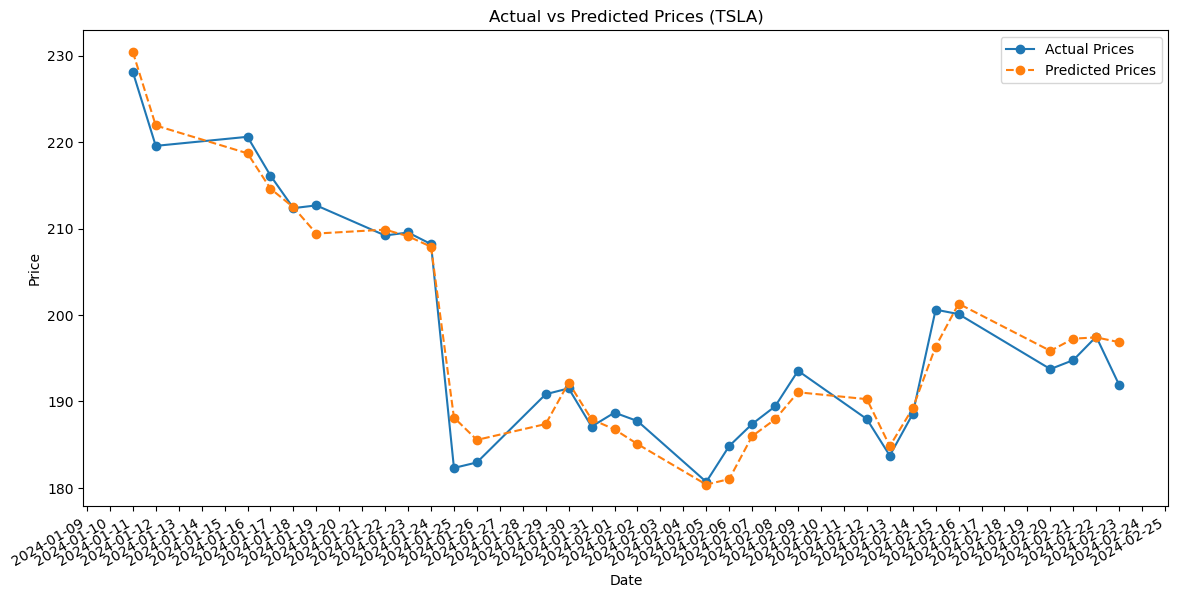

In [23]:
import matplotlib.dates as mdates 

# Plot predictions
def plot_predictions(predictions, actual, dates, title=f'Actual vs Predicted Prices ({ticker})'):
    
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', marker='o')
    plt.plot(dates, predictions, label='Predicted Prices', linestyle='--', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    # Format the x-axis to display dates clearly
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gcf().autofmt_xdate()  # Rotation
    
    plt.show()


predictions = scaler.inverse_transform(
        np.pad(final_predictions, [(0, 0), (0, len(features) - 1)], 'constant'))[:, 0]

actual = scaler.inverse_transform(
        np.pad(y_final_test.reshape(-1, 1), [(0, 0), (0, len(features) - 1)], 'constant'))[:, 0]

test_dates = data.index[-test_size:]

plot_predictions(predictions, actual, test_dates)

## Score

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Calculate evaluation metrics
mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)
rmse = np.sqrt(mse)

r2 = r2_score(actual, predictions)

# Adjusted R-squared
n = test_size  # Number of observations
p = len(scaled_data_df.columns) - 1   # Number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

mape = mean_absolute_percentage_error(actual, predictions)

print("Mean Squared Error (MSE):", round(mse, 2))
print("Mean Absolute Error (MAE):", round(mae, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("R-squared (R2):", round(r2, 2))
print("Adjusted R-squared:", round(adj_r2, 2))
print("Mean Absolute Percentage Error (MAPE):", round(mape, 2))

Mean Squared Error (MSE): 5.99
Mean Absolute Error (MAE): 1.98
Root Mean Squared Error (RMSE): 2.45
R-squared (R2): 0.96
Adjusted R-squared: 0.94
Mean Absolute Percentage Error (MAPE): 0.01


### Mean Squared Error (MSE) and Mean Absolute Error (MAE):
- These metrics measure the average error between the predicted and actual values.
- Lower values indicate better performance.
- However, the absolute scale of these metrics is dependent on the scale of your target variable. Therefore, it's difficult to define a universally "good" threshold. It's more informative to compare these metrics across different models or variations of your LSTM model.

### Root Mean Squared Error (RMSE):
- RMSE is in the same units as the target variable, which can make it more interpretable.
- Similar to MSE and MAE, lower values are desirable.
- Like MSE and MAE, it's more useful for comparing models rather than establishing absolute thresholds.

### R-squared (R2) and Adjusted R-squared:
- R2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
- R2 ranges from 0 to 1, with higher values indicating better fit.
- A value of 1 indicates that the model explains all the variability of the response data around its mean. However, a high R2 value doesn't necessarily mean a good model, as it may overfit.
- Adjusted R-squared adjusts the R2 value based on the number of predictors in the model, providing a more accurate measure of model performance, especially with multiple variables.
- Generally, R2 values closer to 1 and higher Adjusted R-squared values are desirable, but the interpretation depends on the context and the complexity of the model.

### Mean Absolute Percentage Error (MAPE):
- MAPE measures the average absolute percentage difference between predicted and actual values.
- Lower values indicate better performance.
- A MAPE of 0% indicates a perfect fit, but in practice, it's rare to achieve such a value.
- It's common to interpret MAPE in the context of the variability of the target variable. For example, a MAPE below 10% might be considered good in some domains.

## Prediction

In [25]:
# Function to predict future 'n' days
def predict_future_days(model, last_input, scaler, n_days, num_features):
    future_predictions_scaled = []
    
    # Iteratively predict the next 'n' days
    for _ in range(n_days):
        # Predict the next day
        next_day_prediction_scaled = model.predict(last_input)
        
        # Store the scaled prediction
        future_predictions_scaled.append(next_day_prediction_scaled[0, 0])
        
        # Update the input for the next prediction
        last_input = np.append(last_input[:, :, 1:], next_day_prediction_scaled.reshape((1, 1, 1)), axis=2)
    
    # Reshape the predictions to fit the scaler inverse transform
    future_predictions_scaled = np.array(future_predictions_scaled).reshape(-1, 1)
    
    # Correct the padding based on the actual number of features the scaler was fitted with
    scaler_feature_count = len(scaler.scale_)  # Get the number of features the scaler was fitted with
    future_predictions_padded = np.pad(future_predictions_scaled, [(0, 0), (0, scaler_feature_count - 1)], 'constant')

    # Inverse transform to get predictions in original scale
    future_predictions = scaler.inverse_transform(future_predictions_padded)[:, 0]
    
    return future_predictions

# Predict future 'n' days
n_days = 5  # Number of days to predict
num_features = scaled_data_df.shape[1] - 1  # Number of features excluding 'Close'
last_input = scaled_data_df.iloc[-1:, :-1].values.reshape((1, 1, num_features))  # Prepare the last available input

future_predictions = predict_future_days(best_model, last_input, scaler, n_days, num_features)

future_predictions

1/1 [==============================] - 0s 20ms/step


array([196.8554 , 190.25836, 226.3422 , 220.15627, 222.721  ],
      dtype=float32)

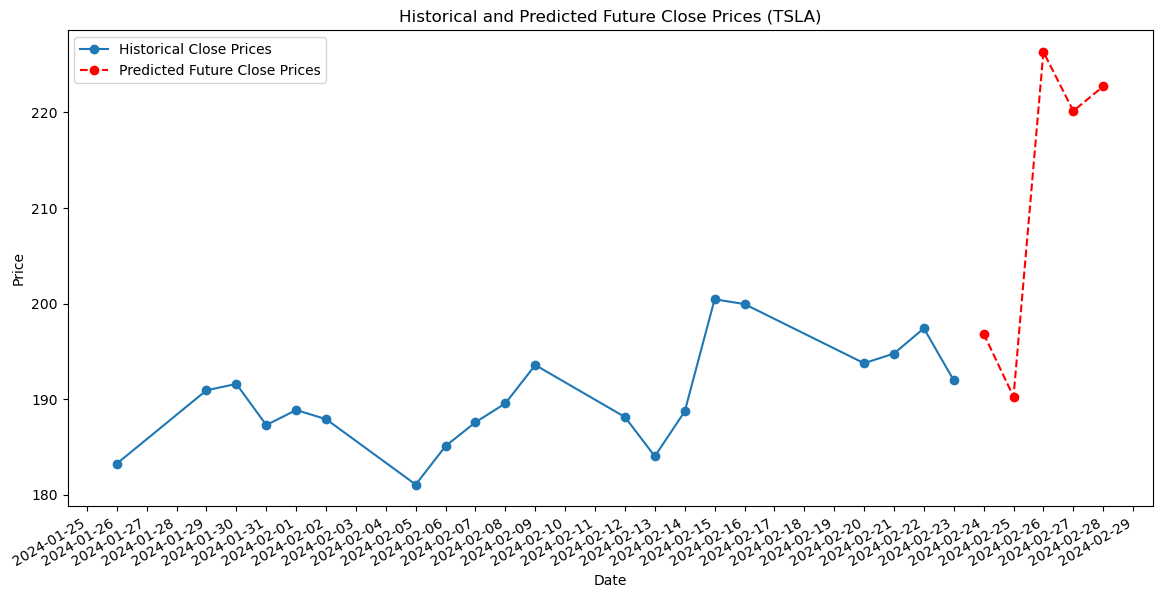

In [26]:
# Plotting Historical and Future Prices
# Historical data
historical_dates = data.index[-20:]  # Last 20 days from the historical data
historical_prices = data['Close'][-20:]

# Future dates for predictions
last_date = historical_dates[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, n_days + 1)]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(historical_dates, historical_prices, label='Historical Close Prices', marker='o')
plt.plot(future_dates, future_predictions, label='Predicted Future Close Prices', linestyle='--', marker='o', color='red')

plt.title(f'Historical and Predicted Future Close Prices ({ticker})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()  # Auto-rotate date labels

plt.show()

## Future Price Prediction Explanation

The future price prediction in this model is achieved through a function that iteratively generates predictions for the desired number of days into the future, based on the most recent data available. This process involves using the latest actual data as input for the first prediction, and then using each subsequent prediction as input for the next. This method is particularly relevant when predicting stock prices where future inputs (e.g., next day's 'Open', 'High', 'Low', etc.) are unknown.

Let's break down the key components of the future price prediction process in the code:

### Last Available Input Preparation

The process starts by preparing the last available input data. This input is the most recent data point available from the dataset, excluding the 'Close' price since that's what we're trying to predict. This is represented in the code as follows:

```python
# Prepare the last available input
num_features = scaled_data_df.shape[1] - 1  # Number of features excluding 'Close'
last_input = scaled_data_df.iloc[-1:, :-1].values.reshape((1, 1, num_features))  # Reshape for LSTM
```

In this snippet:
- `scaled_data_df.iloc[-1:, :-1]` selects the last row of your dataset (the most recent day) and all columns except for the 'Close' price.
- `.values.reshape((1, 1, num_features))` converts this data into the shape expected by the LSTM model, which is `(samples, time steps, features)`. In this case, it's prepared as one sample, with one time step, and a number of features equal to the dataset's features minus the 'Close' column.

### Iterative Future Prediction

The core of the future price prediction is an iterative process where the model uses its most recent prediction as part of the input for the next prediction. This is handled in the `predict_future_days` function:

```python
def predict_future_days(model, last_input, scaler, n_days, num_features):
    future_predictions_scaled = []
    
    for _ in range(n_days):
        next_day_prediction_scaled = model.predict(last_input)
        future_predictions_scaled.append(next_day_prediction_scaled[0, 0])
        
        # Update the input with the most recent prediction
        last_input = np.append(last_input[:, :, 1:], next_day_prediction_scaled.reshape((1, 1, 1)), axis=2)
    
    # Inverse scaling to get predictions in original scale
    future_predictions_scaled = np.array(future_predictions_scaled).reshape(-1, 1)
    future_predictions_padded = np.pad(future_predictions_scaled, [(0, 0), (0, scaler_feature_count - 1)], 'constant')
    future_predictions = scaler.inverse_transform(future_predictions_padded)[:, 0]
    
    return future_predictions
```

In this function:
- The loop `for _ in range(n_days):` iterates for the number of days you want to predict into the future.
- `model.predict(last_input)` generates the next day's price prediction based on the most recent input.
- The prediction is then appended to `future_predictions_scaled` to keep track of all future predictions.
- `last_input` is updated with the new prediction, effectively shifting the input window forward by one day, preparing it for the next prediction cycle.
- After all predictions are made, they are inversely scaled back to the original price scale using the `scaler.inverse_transform` method.

### Final Note

This iterative prediction process allows the model to forecast future stock prices based on learned patterns from historical data. However, it's important to note that as the prediction horizon extends, the reliability of these predictions can decrease due to the compounding of prediction errors and the lack of real future inputs. This approach assumes that past patterns will continue into the future, which may not always hold true in the unpredictable stock market.